## Tutorial for using the brainnetdiff package

In [17]:
import numpy as np
import pandas as pd
import brainnetdiff as bnd
import pickle
from statsmodels.stats.multitest import fdrcorrection

#load data
mmp_atlas = pd.read_csv('data/mmp_atlas.csv')
mmp_xyz = np.load('data/mmp_xyz.npy')
roi_names = list(mmp_atlas.regionLongName)
roi_regions = list(mmp_atlas.cortex_LR)
SC = np.load('data/SC.npy')
FC = np.load('data/FC.npy')
hc_ind = list(range(0,22)) #indices for healthy controls 
pt_ind = list(range(22,87)) #indices for patients 
traits = pd.read_csv('data/demo_idas_baseline.csv')

### 1. Compute the structural to functional brain connectivity mapping 
To do this, we create an object of class BrainNetDiff with the NxNxS structural (SC) and functional (FC) connectomes, where N is the number of nodes from the MMP1.0 parcellation and S is the number of subjects. 

In [4]:
bnd1 = bnd.BrainNetDiff(SC, FC, roi_names, roi_regions)
bnd1.s2f_fit() #fits the model - may take a few minutes to run
bnd1.s2f_map() #computes estimated functional connectomes
s2f_r = bnd1.get_s2f_corr() #use to retrieve the Pearson correlations between estimated and empirical FCs. 
print('mean correlation of mapping = ', np.mean(s2f_r))

100%|██████████| 87/87 [02:47<00:00,  1.93s/it]


mean correlation of mapping =  0.25279358082546305


#### Optional: save mapping parameters 
As the mapping can take a few minutes to compute, you may desire to save the mapping parameters for future analysis. 

In [6]:
bnd1.save_mapping('data/mapping1.npy') #save mapping parameters
bnd1.load_mapping('data/mapping1.npy') #reload mapping parameters
bnd1.s2f_map()

### 2. Compute SDD connectomes from diffusion embedding and run NBS
Next we compute the structural diffusion distance (SDD) connectomes using the diffusion depth mapping parameters. Then we run the network-based statistic (NBS) algorithm on the SDD connectomes. Here, and a left sided t-test NBS with 1000 permutations and t-statistic threshold of 4.0 is run between healthy controls and patients. 

In [7]:
bnd1.SDD_compute()
bnd1.nbs_ttest(group1_idx=hc_ind, group2_idx=pt_ind, thresh=4, tail='left', nperms=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

generating null distribution


  3%|▎         | 29/1000 [00:00<00:03, 284.57it/s]

Maximum component size:
number of nodes =  48.0
number of edges =  74
estimating null distribution with 1000 permutations


100%|██████████| 1000/1000 [00:03<00:00, 297.32it/s]


### Optional: save null distribution 
As generating the null distribution, especially using a high number of permutation, can take a few minutes to run, one can optionally save the null distribution and reload it for future use. 

In [8]:
bnd1.save_null_dist('data/null_dist1.npy', 'ttest') #save null distribution 
#bnd1.load_null_dist('data/null_dist1.npy', 'ttest') #use to reload null distribution to run more NBS analyses

In [9]:
bnd1.make_nbs_df() #compile data from NBS
bnd1.get_nbs_df() #retrieve dataframe with data from NBS

,nbs_idx,alt_hypo,stat_thresh,trait,size,pval,rois,regions
0,1,left,4,None,48,0.004,"[Area_ventral_23_a+b_L, Area_7PC_L, Area_9_Mid...","[Posterior_Cingulate_L, Superior_Parietal_L, A..."


### Create plots for an NBS run
Now, connectome and bar plots can be created from data from a row of the above dataframe and specified in the plotting method by the corresponding index in the 'nbs_idx' column of the dataframe. Specifies a path with a path and filename to save the plots. *Note: a modified version of nilearn is required for plotting functions - see README.md.

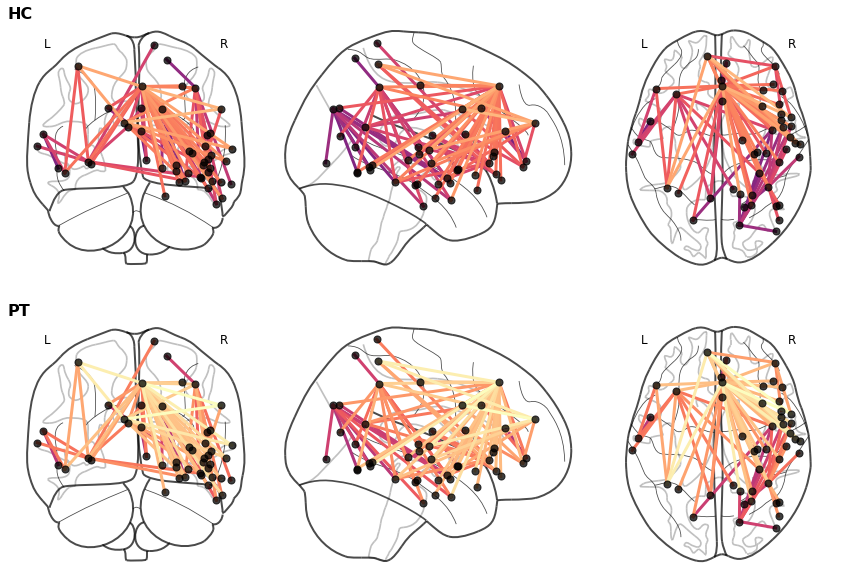

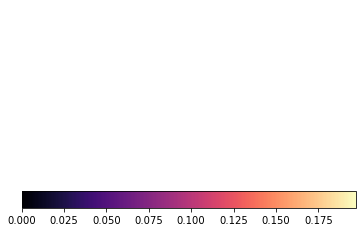

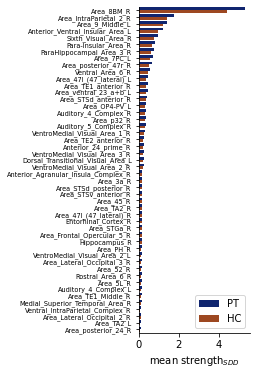

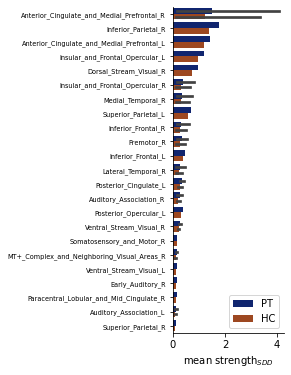

In [11]:
bnd.vis.ctm_plot2group(bnd1, nbs_idx=1, xyz=mmp_xyz, path=None)

## 3. Run diffusion analyses 
Next, compute heat kernels at the diffusion depth identified in the structural to functional mapping to find correlations of heat kernel values and traits of interest and identify optimal modulatory brain regions. In this example, we use regional averages as nodes, as determined by the cortical regions for each individual node in the MMP1.0 parcellation. 

In [12]:
bnd1.diffusion_analysis(nbs_idx=1, heat_val=1, by_region=True)

### Heat kernel value correlations
First, we demonstrate how to compute correlations and corresponding plots between heat kernel values (HKVs) and a trait of interest - in this example, baseline IDAS-II Depression. We also filter the data to only include HKVs between nodes of interest. 

In [19]:
trait = traits.idas_depression.values 
bnd1.hk_correlation(trait[pt_ind], subset_ind=pt_ind, mcc=True) #compute correlations 
cordf = bnd1.get_correlation_df() 
#the following lines are used to filter the dataframe for rows of interest. 
r1 = 'Anterior_Cingulate_and_Medial_Prefrontal_L'
r2 = 'Anterior_Cingulate_and_Medial_Prefrontal_R'
cordf = cordf.loc[(cordf['roi1'] == r1) | (cordf['roi1'] == r2) |\
                   (cordf['roi2'] == r1) | (cordf['roi2'] == r2)].copy()
cordf['qval2'] = fdrcorrection(cordf.pval.values)[1] #add FDR corrected p-values
cordf = cordf.sort_values('pval')
cordf.query('qval2 < 0.05') #look at dataframe to see rows of interest, queried for significance 

,roi1,roi2,stat,pval,stat_idx,qval,roi1_ind,roi2_ind,qval2
1,Anterior_Cingulate_and_Medial_Prefrontal_L,Posterior_Cingulate_L,0.393220,0.001194,1,0.153436,2,0,0.035985
94,Anterior_Cingulate_and_Medial_Prefrontal_R,Inferior_Frontal_L,-0.364835,0.002808,94,0.153436,14,3,0.035985
17,Insular_and_Frontal_Opercular_L,Anterior_Cingulate_and_Medial_Prefrontal_L,-0.355752,0.003634,17,0.153436,6,2,0.035985
5,Inferior_Frontal_L,Anterior_Cingulate_and_Medial_Prefrontal_L,-0.354439,0.003770,5,0.153436,3,2,0.035985
38,Dorsal_Stream_Visual_R,Anterior_Cingulate_and_Medial_Prefrontal_L,0.350674,0.004184,38,0.153436,9,2,0.035985
23,Ventral_Stream_Visual_L,Anterior_Cingulate_and_Medial_Prefrontal_L,0.340301,0.005543,23,0.171372,7,2,0.039724


### Correlation plots 
Now, similar to the NBS dataframe, we choose indices via the stat_idx parameter of the below plotting method. *Note: a modified version of nilearn is required for plotting functions - see README.md.

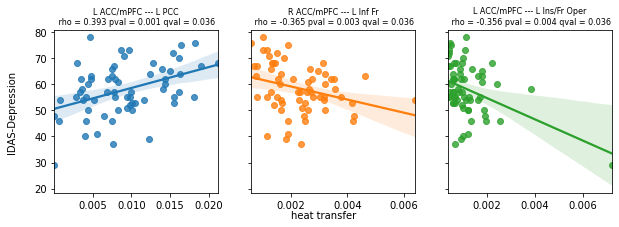

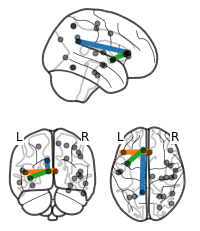

In [20]:
regplot_titles = ['L ACC/mPFC --- L PCC', 'R ACC/mPFC --- L Inf Fr',
                  'L ACC/mPFC --- L Ins/Fr Oper']
bnd.vis.hk_cor_plot(bnd1, cordf, stat_idx=[1, 94, 17], 
                    xyz=mmp_xyz, trait=trait[pt_ind], 
                    trait_name='IDAS-Depression',
                    subset_ind=pt_ind, 
                    regplot_titles=regplot_titles)

## 4. Optimal heat modulation 
We can also identify optimal putative targets for stimulatory neuromodulation, modelled by supplementing heat kernels with a constant amount of heat at a node. In this example, we identify the best, on average, node (given by mean cortical regions) that results in normalization of patient heat kernels towards that of the average healthy control. 

In [21]:
bnd1.hk_modulation(min_type='heat', group_min=True) #compute optimal brain regions
#bnd1.get_opt_modulation_df() #use to get dataframe with heat kernel modulation data
bnd1.hk_modulation_compare(thresh=0.05, use_mcc=True) #compare pre- vs post-modulation heat kernel values via t-test
#bnd1.get_hk_modulation_df() #use to get dataframe with comparison and plotting data

### Heat kernel modulation plots 
Use this method to visualize effectiveness of optimal modulation identified above for correcting diffusion deficits in patient heat kernels. *Note: a modified version of nilearn is required for plotting functions - see README.md.

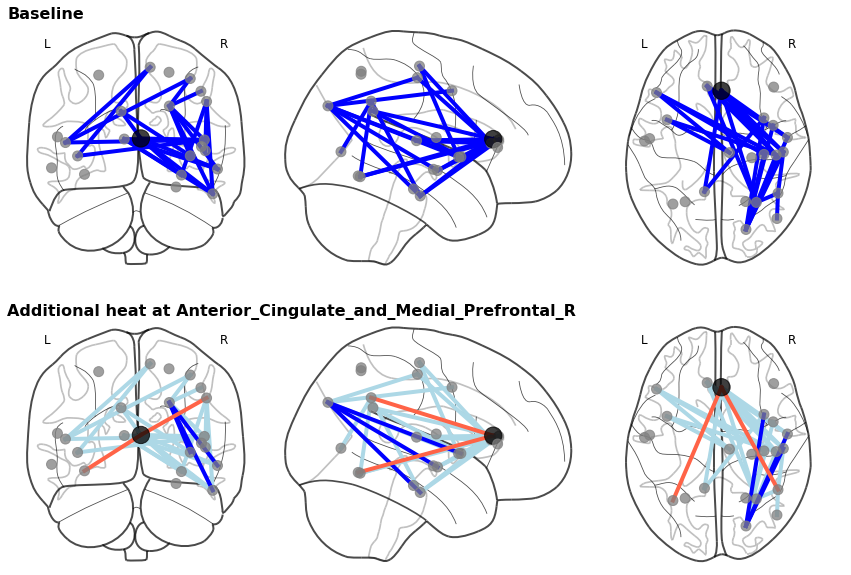

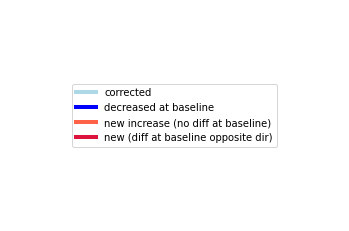

In [23]:
bnd.vis.ctm_plot_hk_modulation(bnd1, mmp_xyz)